# 2A.ml - Arbres, forêts aléatoires et extensions - corrigé- Gabriel ROMON

Cet énoncé est une version modifiée de celui de Xavier Dupré.

In [1]:
%matplotlib inline
import urllib.request
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb

# Données

Le package `pickle` permet de sauvegarder n'importe quel objet Python (liste, numpy array, ...) en un fichier afin que cet objet puisse être sauvegardé ou partagé. C'est très pratique lorsque l'objet en question est le fruit d'un calcul long (poids d'un réseau de neurones, hyperparamètres d'un modèle, ...).

On télécharge le fichier `.pickle` depuis mon Github et on l'ouvre. C'est une liste de 3 éléments `[X, y, X_private]`. Le but est d'entraîner un modèle sur `X, y` et de prédire `y_private` (qui est une variable continue).

Vous m'enverrez un fichier `.pickle` contenant vos prédictions et je vais évaluer le MSE correspondant: $$\text{MSE}=\frac 1n\sum_{i=1}^n (y_i-\hat{y}_i)^2$$

C'est un mini-Kaggle !

In [2]:
url = 'https://github.com/gabsens/Python-for-Data-Scientists-ENSAE/raw/master/TD2/data.pickle'
urllib.request.urlretrieve(url, './data.pickle')

with open("data.pickle", "rb") as f:
    X, y, X_private = pickle.load(f)

In [3]:
X.shape

(15480, 8)

In [4]:
X_private.shape

(5160, 8)

# Exercice 1: Mini-Kaggle, tuning de modèles

Afin de juger de la qualité des modèles entrainés, il faut couper le jeu de données en deux.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=95)

In [6]:
X_train.shape

(11610, 8)

In [7]:
X_test.shape

(3870, 8)

## a) Entraîner une régression linéaire

On commence toujours par le modèle le plus simple: la régression linéaire. C'est un modèle peu complexe, mais au moins il ne risque pas d'overfitter.

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lin = LinearRegression().fit(X_train, y_train)

print('MSE:', '\ntrain:', mean_squared_error(y_train, lin.predict(X_train)),
              '\ntest:', mean_squared_error(y_test, lin.predict(X_test))
     )

MSE: 
train: 0.515074118251781 
test: 0.5375695523360391


Vous devez obtenir à peu près le même MSE sur le train et le test. Ces scores constituent la baseline.

## b) Entraîner un arbre de décision

Ne touchez à aucun hyperparamètre dans un premier temps.

In [17]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

print('MSE:', '\ntrain:', mean_squared_error(y_train, tree.predict(X_train)),
              '\ntest:', mean_squared_error(y_test, tree.predict(X_test))
     )

MSE: 
train: 5.653651066659692e-14 
test: 0.5390846928573527


Le MSE sur le train est quasi 0, alors que le MSE sur le test est proche de celui de la régression linéaire. Le modèle overfit terriblement !  

Il va falloir jouer sur les hyperparamètres. Pour cela, il faut comprendre comment fonctionnent les arbres de décision...
***

Les arbres de décision de Scikit-Learn sont des arbres binaires (chaque noeud a exactement 2 fils). Ils sont construits récursivement en partant de la racine. Regardez l'arbre ci-dessous: étant donné un nouvel example $(x_1,\ldots,x_8)$, on regarde d'abord si $x_1\leq 5.148$. Si c'est le cas, on regarde ensuite si $x_1\leq 3.071$. Si oui, le $\hat y$ prédit est $1.352$. Sinon, on regarde si $x_6\leq 2.344$. Si c'est le cas, on prédit $2.841$, et sinon on prédit $1.895$.

A chaque noeud on peut associer les exemples de la base d'entrainement (les lignes de `X_train`) qui vérifient les conditions menant à ce noeud. Le nombre de telles lignes est donné par `samples=...`, la valeur $\hat y$ que l'arbre leur assigne est donnée par `value=...`, et le MSE correspondant à cette prédiction est donné par `mse=...`.  
Par exemple, dans l'arbre ci-dessous, considérons la condition $$(x_1\leq 5.148) \text{ and } (x_1> 3.071) \text{ and } (x_6>2.344)$$
$3861$ lignes la vérifient et la prédiction associée à ces lignes est $1.895$.

Décrivons succinctement l'algorithme de croissance des arbres. Un noeud de l'arbre est entièrement caractérisé par la variable $x_k$ et le seuil $t_k$ à partir desquels la condition $x_k\leq t_k$ est créée. La racine de l'arbre est créée en cherchant $(k, t_k)$ qui minimise $$\frac{m_{\text{gauche}}}{m} \text{MSE}_{\text{gauche}}+\frac{m_{\text{droite}}}{m} \text{MSE}_{\text{droite}}$$
où $m$ est le nombre total de samples (le nombre de lignes de `X_train`), $m_{\text{gauche}}$ est le nombre de samples qui vérifient la condition $x_k\leq t_k$ et $\text{MSE}_{\text{gauche}} = \sum_{i \in \text{gauche}} (y^{(i)}-\hat y_{\text{gauche}}
)^2$ où la valeur prédite dans le fils gauche est $\hat y_{\text{gauche}} = \frac{1}{m_{\text{gauche}}} \sum_{i \in \text{gauche}} y^{(i)}$.  
La croissance de l'arbre se poursuit en répétant le procédé sur le fils gauche et le fils droit de la racine (etc).

Il faut des conditions d'arrêt qui disent quand stopper la croissance de l'arbre. Si l'arbre est trop complexe (trop de noeuds/feuilles), il va overfitter les données. C'est là qu'interviennent les hyperparamètres:
* `max_depth`: la profondeur maximale de l'arbre 
* `max_leaf_nodes`: nombre maximal de feuilles dans l'arbre
* `min_samples_split`: un noeud qui a moins de `min_samples_split` samples est automatiquement une feuille
* `min_samples_leaf`: nombre minimum de samples dans chaque noeud (un split ne sera envisagé que si il y a au moins `min_samples_leaf` samples dans le fils gauche et `min_samples_leaf` samples dans le fils droit).


En mettant `max_depth` petit, `max_leaf_nodes` petit, `min_samples_split` grand, et `min_samples_leaf` grand, on limite l'overfitting.

In [21]:
from graphviz import Source
from sklearn.tree import export_graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Temp/release/bin'

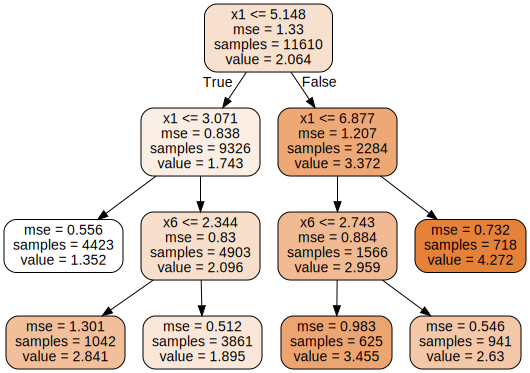

In [22]:
tree = DecisionTreeRegressor(max_depth=3, max_leaf_nodes=6)
tree.fit(X_train, y_train)

export_graphviz(
        tree,
        out_file="./regression_tree.dot",
        feature_names=["x"+str(i) for i in range(1,9)],
        rounded=True,
        filled=True
    )
Source.from_file("./regression_tree.dot")

***

## Question importante: comment choisir les hyperparamètres ?

On ne peut pas simplement essayer différentes hyperparamètres et consulter la performance sur `X_test`. Si on fait ça, on va overfit le `X_test` !

Il faut choisir les hyperparamètres par validation croisée ($k$-fold cross-validation).

In [51]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,4,5,7,10,15,20], 'min_samples_leaf':range(1,10),
              'min_samples_split':range(2,10)}
tree = DecisionTreeRegressor() 
tree_search = GridSearchCV(tree, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1)
tree_search.fit(X_train, y_train)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 2952 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 5704 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  1.1min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 7, 10, 15, 20],
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10)},
             pre_dispatch=

ci-dessous les perfs du meilleur modèle (sur chacun des 10 folds):

In [58]:
[-v[tree_search.best_index_] for (k,v) in tree_search.cv_results_.items() if k.startswith('split')]

[0.3967812850061739,
 0.41345941139209036,
 0.400720122410235,
 0.47374972605831284,
 0.38450011085565255,
 0.4202797996579079,
 0.4043485602541037,
 0.422875591800359,
 0.4075115015096375,
 0.3906582167179846]

La moyenne de ces MSE est directement accessible:

In [59]:
-tree_search.best_score_

0.41148843256624573

Les meilleurs hyperparamètres:

In [54]:
tree_search.best_params_

{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2}

La fonction `GridSearchCV` prend les meilleurs hyperparamètres et les utilise pour entrainer le modèle sur tout `X_train`. On accède au modèle final avec `tree_search.best_estimator_`:

In [60]:
tree = tree_search.best_estimator_
print('MSE:', '\ntrain:', mean_squared_error(y_train, tree.predict(X_train)),
              '\ntest:', mean_squared_error(y_test, tree.predict(X_test))
     )

MSE: 
train: 0.2581126516528247 
test: 0.41364969822443814


Le modèle overfit certes, mais le MSE sur le test est très proche du MSE calculé par cross-validation. Donc on arrive bien à prévoir la capacité du modèle à généraliser.

## c) Entraîner un random forest

Ne touchez à aucun hyperparamètre dans un premier temps.

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

print('MSE:', '\ntrain:', mean_squared_error(y_train, rf.predict(X_train)),
              '\ntest:', mean_squared_error(y_test, rf.predict(X_test))
     )

L:\WinPython\python-3.6.6.amd64\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


MSE: 
train: 0.05300230936779286 
test: 0.2930152237163136


Comme attendu, le modèle overfit beaucoup.

Grossièrement, un random forest est une moyenne d'un grand nombre d'arbres de décision. Les hyperparamètres sont donc très similaires aux précédents (il faut en plus choisir le nombre d'arbres `n_estimators`).

In [63]:
from sklearn.ensemble import RandomForestRegressor

parameters = {'max_depth':[2,3,4,5,6,7,8], 'min_samples_leaf':[1,2,3,4,5,6],
              'max_features':["auto"], 'n_estimators':[10,20,30,40,50]}
rf = RandomForestRegressor()
rf_search = GridSearchCV(rf, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1)
rf_search.fit(X_train, y_train)

Fitting 10 folds for each of 210 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:  6.1min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 

In [64]:
[-v[rf_search.best_index_] for (k,v) in rf_search.cv_results_.items() if k.startswith('split')]

[0.31412747224478743,
 0.33240025878389157,
 0.3205169171798233,
 0.35747842327414614,
 0.31595881523786473,
 0.3494175731191536,
 0.31592927905735,
 0.3746973167349527,
 0.30656018536020563,
 0.31199181796390957]

In [65]:
-rf_search.best_score_

0.3299078058956084

In [66]:
rf_search.best_params_

{'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'n_estimators': 50}

In [67]:
rf = rf_search.best_estimator_
print('MSE:', 'train:', mean_squared_error(y_train, rf.predict(X_train)),
              'test:', mean_squared_error(y_test, rf.predict(X_test))
     )

MSE: train: 0.24940160680121298 test: 0.33605346214901327


### 2ème tentative en raffinant ce qu'on a trouvé

In [68]:
parameters = {'max_depth':[7,8,9,10,11], 'min_samples_leaf':[1,2,3],
              'n_estimators':[40,50,60,70]}
rf = RandomForestRegressor()
rf_search = GridSearchCV(rf, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1)
rf_search.fit(X_train, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  5.4min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [7, 8, 9, 10, 11],


In [69]:
[-v[rf_search.best_index_] for (k,v) in rf_search.cv_results_.items() if k.startswith('split')]

[0.28197782081362294,
 0.2916967889629732,
 0.27348200022477076,
 0.3094498074419222,
 0.27303765168208033,
 0.2978301724111948,
 0.272525493710379,
 0.3253057128965016,
 0.2531161937171129,
 0.2663949656702875]

In [70]:
-rf_search.best_score_

0.28448166075308456

In [71]:
rf_search.best_params_

{'max_depth': 11, 'min_samples_leaf': 3, 'n_estimators': 70}

In [73]:
rf = rf_search.best_estimator_
print('MSE:', 'train:', mean_squared_error(y_train, rf.predict(X_train)),
              'test:', mean_squared_error(y_test, rf.predict(X_test))
     )

MSE: train: 0.14317293137433595 test: 0.28511666703503513


On a un MSE en cross-val sur le train et un MSE sur le test proches de $0.285$, c'est bien !

Je suis satisfait de la performance du modèle, donc c'est le bon moment pour voir ce qu'il vaut vraiment sur de nouvelles données (i.e sur `X_private`). Je rappelle que vous n'avez pas accès à `y_private`, mais moi si.

In [75]:
y_pred = rf.predict(X_private)

In [26]:
with open("yprivate.pickle", "rb") as f:
    y_private = pickle.load(f)

In [77]:
mean_squared_error(y_pred, y_private)

0.28245768089476747

La capacité de généralisation du modèle est confirmée: on a la même performance sur le test que sur le private.

### 3 ème tentative

In [78]:
parameters = {'max_depth':[11,15,20], 'min_samples_leaf':[1,2,3,4,5],
              'n_estimators':[70,100,150]}
rf = RandomForestRegressor()
rf_search = GridSearchCV(rf, parameters, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, verbose=1)
rf_search.fit(X_train, y_train)

Fitting 10 folds for each of 45 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  9.9min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [11, 15, 20],
     

In [81]:
rf_search.best_params_

{'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 150}

In [14]:
rf = RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_estimators=150)
rf.fit(X_train, y_train)
print('MSE:', '\ntrain:', mean_squared_error(y_train, rf.predict(X_train)),
              '\ntest:', mean_squared_error(y_test, rf.predict(X_test))
     )

MSE: 
train: 0.05885930059949651 
test: 0.26632698653622233


In [86]:
y_pred = rf.predict(X_private)

In [87]:
mean_squared_error(y_pred, y_private)

0.2610297733844857

### 4 ème tentative

In [88]:
parameters = {'max_depth':[15,20,25,30,35], 'min_samples_leaf':[1,2,3,4,5],
              'n_estimators':[120,150,170,200,250]}
rf = RandomForestRegressor()
rf_search = GridSearchCV(rf, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed: 20.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [15, 20, 25, 30, 35]

In [89]:
rf_search.best_params_

{'max_depth': 35, 'min_samples_leaf': 1, 'n_estimators': 200}

In [29]:
rf = RandomForestRegressor(max_depth=35, min_samples_leaf=1, n_estimators=200)
rf.fit(X_train, y_train)
print('MSE:', '\ntrain:', mean_squared_error(y_train, rf.predict(X_train)),
              '\ntest:', mean_squared_error(y_test, rf.predict(X_test))
     )

MSE: 
train: 0.03652540908006555 
test: 0.26239096844368476


In [30]:
y_pred = rf.predict(X_private)

In [31]:
mean_squared_error(y_pred, y_private)

0.25729530646987675

On obtient pas significativement mieux sur le test par rapport à la tentative précédente. En revanche, on a de la chance sur le private vu qu'on obtient $0.257$ en MSE.

Le gridsearch était plutôt long (20 minutes) et le gain négligeable, il est raisonnable de passer à un autre modèle que les random forests.

## d) Entraîner un xgboost

On ne touche pas trop aux hyperparamètres dans un premier temps.

In [34]:
#Si vous avez une version récente de xgboost il faut remplacer reg:linear par reg:squarederror
param = {'max_depth':3, 'eta':1, 'silent':1, 'objective':'reg:linear'}

bst = xgb.train(params=param, dtrain=xgb.DMatrix(X_train, label=y_train))

print('MSE:', '\ntrain:', mean_squared_error(y_train, bst.predict(xgb.DMatrix(X_train))),
              '\ntest:', mean_squared_error(y_test, bst.predict(xgb.DMatrix(X_test)))
     )

MSE: 
train: 0.3072673651550215 
test: 0.35606410551823686


In [23]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[3,5,7,10,15,20], 'eta':np.arange(0.1,2,0.3),
              'objective':['reg:squarederror']}  #avec une version ancienne de xgboost il faut mettre reg:linear

bst = xgb.XGBRegressor(num_boost_round=30, early_stopping_rounds=5)
bst_search = GridSearchCV(bst, parameters, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)
bst_search.fit(X_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  2.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, early_stopping_rounds=5,
                                    gamma=0, importance_type='gain',
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=3, min_child_weight=1,
                                    missing=None, n_estimators=100, n_jobs=1,
                                    nfold=10, nthread=None, num_b...
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'eta': array(

In [29]:
-bst_search.best_score_

0.23320549287225628

In [25]:
bst_search.best_params_

{'eta': 0.1, 'max_depth': 7, 'objective': 'reg:squarederror'}

In [28]:
bst = bst_search.best_estimator_
print('MSE:', 'train:', mean_squared_error(y_train, bst.predict(X_train)),
              'test:', mean_squared_error(y_test, bst.predict(X_test))
     )

MSE: train: 0.09091648209189733 test: 0.23192689346104273


In [31]:
with open("yprivate.pickle", "rb") as f:
    y_private = pickle.load(f)
    
y_pred = bst.predict(X_private)

mean_squared_error(y_pred, y_private)

0.22086412567310826

Sans tuner trop on a un MSE de 0.23 en cross-val sur le train, 0.23 sur le test, et 0.22 sur le private (coup de chance).

Les arbres boostés sont des modèles très puissants. Ils sont de plus rapides à entrainer. Il faut en revanche faire attention à l'overfitting.